In [11]:
from localmd.decomposition import localmd_decomposition, display, factored_svd, windowed_pmd, single_residual_block_md, get_projector
from localmd.dataset import TiffArray
from localmd.pmdarray import PMDArray
import matplotlib.pyplot as plt


import scipy
import scipy.sparse
import jax
import jax.scipy
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
import math

import os
import tifffile

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Specify the dataset in the below panel. See PMD documentation for easy ways to add support for your custom data formats. We provide default support for single, multipage tiff files. 

In [6]:
input_file = "../datasets/demoMovie.tif"
current_dataset = TiffArray(input_file)

# Below panel specifies the parameters for running the method

In [7]:
#Default parameters (can be modified..)

pmd_params_dict = {
    'block_height':32,
    'block_width':32,
    'frames_to_init':5000,
    'background_rank':1,
    'max_consec_failures':1,
    'max_components':40,
    'rank_prune': False,
}


#NOTE: this data folder will also contain the location of the TestData
block_height = pmd_params_dict['block_height']
block_width = pmd_params_dict['block_width'] 

block_sizes = [block_height, block_width]

rank_prune=pmd_params_dict['rank_prune']
max_consec_failures = pmd_params_dict['max_consec_failures']
frames_to_init = pmd_params_dict['frames_to_init']
background_rank = pmd_params_dict['background_rank'] 

###THESE PARAMS ARE NEVER MODIFIED
sim_conf = 5

max_components = pmd_params_dict['max_components']

registration_routine = None

frame_batch_size = 2000
pixel_batch_size = 10000
dtype="float32"

# Run PMD

In [8]:
current_video = localmd_decomposition(current_dataset, block_sizes, frames_to_init, \
                                max_components=max_components, background_rank = background_rank, sim_conf=sim_conf,\
                                 frame_batch_size=frame_batch_size,pixel_batch_size=pixel_batch_size, dtype=dtype, \
                                 num_workers=0, registration_routine=registration_routine, max_consec_failures=max_consec_failures,
                                     rank_prune=rank_prune)

[24-03-07 08:17:43]: The batch size used is 2000
[24-03-07 08:17:43]: num workers for each dataloader is 0
[24-03-07 08:17:43]: Computing Video Statistics
[24-03-07 08:17:43]: Calculating mean and noise variance
[24-03-07 08:17:48]: Finished mean and noise variance
[24-03-07 08:17:48]: WARNING: Specified using more frames than there are in the dataset.
[24-03-07 08:17:48]: WARNING: Initializing on less than 2000 frames, this will lead to limited benefits.
[24-03-07 08:17:48]: We are initializing on a total of 2000 frames
[24-03-07 08:17:48]: Running Simulations, block dimensions are 32 x 32 x 2000 
[24-03-07 08:17:51]: Loading Data
[24-03-07 08:17:51]: Obtaining blocks and running local SVD
[24-03-07 08:17:52]: Normalizing by weights
[24-03-07 08:17:52]: The total rank before pruning is 481
[24-03-07 08:17:52]: Performing rank pruning and orthogonalization for fast sparse regression.
[24-03-07 08:17:53]: After performing rank reduction, the updated rank is 481
[24-03-07 08:17:53]: Runn

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]

[24-03-07 08:17:53]: Final reformat of data into complete SVD
[24-03-07 08:17:53]: Short matrix, using leftward SVD routine


[24-03-07 08:17:54]: Matrix decomposition completed


# The PMDArray object is a convenient representation of the PMD decomposition of the data. You can use this object to interact with the decomposition via standard "array-like" functionality: 


### CAUTION: Doing something like current_video[:, :, :] will involve returning the full dataset. You'll notice PMD is a massively compressed representation of the data and can fit into your system's RAM, thanks to a matrix factorization. By running current_video[:, :, :] you are expanding out that matrix factorization and explicitly returning a matrix whose dimensions is the dimensions of your full movie: for big data this will construct a movie of shape (data_shape). Instead, intended use is to look at subsets of the data efficiently (load some frames, spatially crop the data, and do combinations of these two operations) like below: 

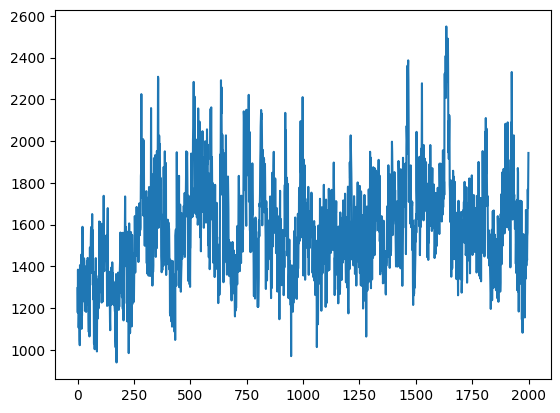

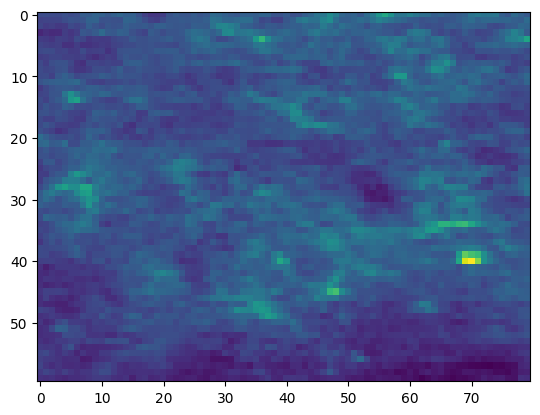

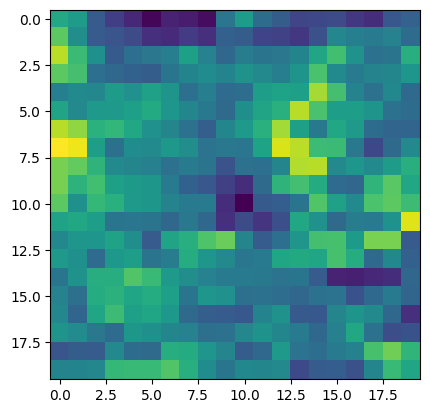

In [9]:
#Here is how to plot single pixels of the data:
plt.figure()
plt.plot(current_video[:, 30, 40])
plt.show()

#Here is how to work with frames of the data: 
plt.figure()
plt.imshow(current_video[100, :, :])
plt.show()


#Here is how to do both combinations of things: 
plt.figure()
plt.imshow(current_video[50, 20:40, 10:30])
plt.show()

# Save the individual matrices of the PMD decomposition into a NPZ file

In [13]:
npz_save_name = "INSERT_SAVE_NAME_HERE.npz"
U = current_video.U_sparse
R = current_video.R
s = current_video.s
V = current_video.V
mean_img = current_video.mean_img
std_img = current_video.var_img
data_shape = current_video.shape
order = current_video.order


np.savez(npz_save_name, fov_shape = data_shape[1:], \
                fov_order=order, U_data = U.data, \
                U_indices = U.indices,\
                U_indptr=U.indptr, \
                U_shape = U.shape, \
                U_format = type(U), \
                R = R, \
                s = s, \
                Vt = V, \
                 mean_img = mean_img, \
                 noise_var_img = std_img)

# How to load the data from our standard .npz representation

In [17]:
data = np.load(npz_save_name, allow_pickle=True)
U = scipy.sparse.csr_matrix(
    (data['U_data'], data['U_indices'], data['U_indptr']),
    shape=data['U_shape']
).tocoo()
V = data['Vt']
R = data['R']
s = data['s']
mean_img = data['mean_img']
std_img = data['noise_var_img']
data_shape = (V.shape[1], data['fov_shape'][0], data['fov_shape'][1])
data_order = data['fov_order'].item()

current_video = PMDArray(U, R, s, V, data_shape, data_order, mean_img, std_img)

# Generate a comparison triptych to show how well PMD retains signal from the original movie

In [18]:
cropped_dataset = current_dataset[:, :, :]
cropped_pmd = current_video[:, :, :]
cropped_residual = cropped_dataset - cropped_pmd

output_triptych = np.concatenate([cropped_dataset, cropped_pmd, cropped_residual], axis = 2)

## Modify the filename below as desired
filename_to_save = "Denoised_Vs_Raw_Comparison.tiff"

#The below line saves the tiff file
tifffile.imwrite(filename_to_save, output_triptych)